In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from prophet import Prophet, plot, diagnostics
from prophet.diagnostics import cross_validation, performance_metrics

from mlflow import (
    log_metric,
    log_param,
    log_artifacts,
    get_artifact_uri,
    active_run,
    get_tracking_uri,
    log_artifact,
    create_experiment,
    set_experiment
)
import mlflow

# Develop MLflow conventions using prophet based models

## Load data

In [2]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [4]:
pabrc = load_data_local('../data/station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
weekly = pabrc.resample('W').mean()

In [8]:
weekly_prophet = (weekly
    .rename(columns={'ICE_C_GDS0_SFC_ave6h': 'y'})
    .reset_index()
    .rename(columns={'index': 'ds'})
)

## Orignal method for training model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -85.914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       698.905   0.000304959       77.3222           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       698.938   0.000281443       67.2427   3.554e-06       0.001      184  LS failed, Hessian reset 
     150       698.953   3.48351e-08       69.4328       0.316           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


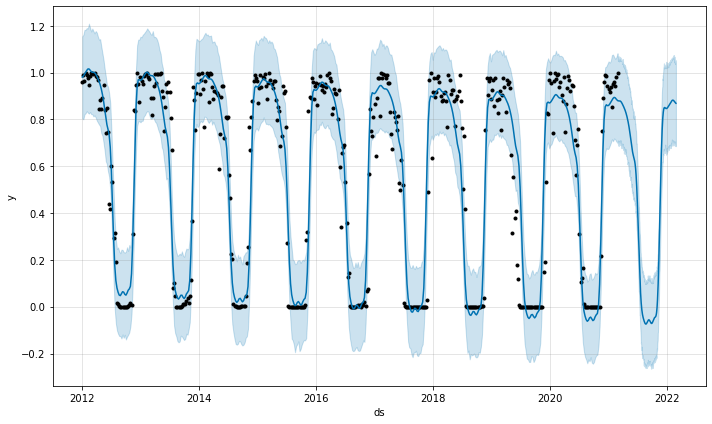

In [9]:
with mlflow.start_run():

    model = Prophet()
    model.fit(weekly_prophet)

    # future = m.make_future_dataframe(periods=365)
    # forecast = m.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
    metrics_raw = cross_validation(
        model=model,
        horizon="365 days",
        period="180 days",
        initial="710 days",
        parallel="threads",
        disable_tqdm=True,
    )
    cv_metrics = performance_metrics(metrics_raw)
    metrics = {k: cv_metrics[k].mean() for k in metric_keys} 

## Convert orginal notebook method to log data from training runs

Parameters:
- [x] Use remote tracker set via `mlflow.set_tracking_uri()`: http://mlflow.srv.axiomptk
- Log model parameters via `mlflow.log_params()`
- Log model skills via `mlflow.log_metric()`
- [x] Create and set an experiment name via `mlflow.set_experiment()`
- Set tags for the experiment using `mlflow.set_tags()`
    - ideas: dvc data version (git tag), experiment type?


### First need ot set the `tracking URI`

In [22]:
TRACKING_URI = 'http://mlflow.srv.axiomptk:80'
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.get_tracking_uri()

'http://mlflow.srv.axiomptk:80'

### Create and set experiment

In [23]:
experiment_id = mlflow.create_experiment("S2S_prophet")
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: S2S_prophet
Experiment_id: 1
Artifact Location: /mlflow/artifacts/1
Tags: {}
Lifecycle_stage: active


In [25]:
mlflow.set_experiment("S2S_prophet")

### Try running an example

In [ ]:
with mlflow.start_run():

    model = Prophet()
    model.fit(weekly_prophet)
    #future = model.make_future_dataframe(periods=365)
   

    df_cv = diagnostics.cross_validation(basic, cutoffs=cutoffs,
        horizon='365 days'
)

### Set tags (Do this under an active run or a new active run will be created)

tag ideas:
- project
- dvc data version
